# Recurrent Neural Networks - The Draft
### 2022/07/22, Ahmed J. Zerouali
#### Updated: 22/07/24



## Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime

In [2]:
%matplotlib inline

In [3]:
# PyTorch
import torch as T
import torch.nn as nn
import torch.nn.functional as F

In [4]:
# Data processing

# SKlearn MinMaxScaler
from sklearn.preprocessing import MinMaxScaler

# DataLoader
from torch.utils.data import Dataset, DataLoader


In [5]:
# Torch Layers
from torch.nn import Module, RNN, LSTM

## Data

### Generate the synthetic data

In [6]:
# Generate synthetic data
t = np.linspace(start=0, stop=10, num=501)
X_ini = np.sin(2*np.pi*t)

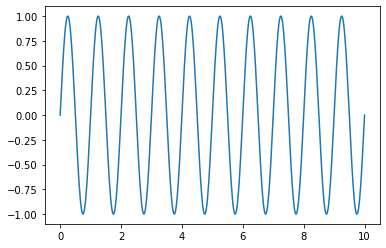

In [7]:
plt.plot(t,X_ini)

This is our data. Now let's take 10% of it as a 

In [8]:
# Test percentage and index
test_data_percentage = 0.1
test_data_idx = len(X_ini)-int(len(X_ini)*test_data_percentage)

# Train-test split
X_train_ini = X_ini[:test_data_idx]
X_test_ini = X_ini[test_data_idx:]

In [9]:
X_test_ini.shape

(50,)

### Scale with MinMaxScaler()

In [9]:
# Inst. scaler
ts_scaler = MinMaxScaler()

# Fit scaler on training data
ts_scaler.fit(X_train_ini.reshape(-1,1))

# Scale train and test data
X_train = ts_scaler.transform(X_train_ini.reshape(-1,1))[:,0]
X_test = ts_scaler.transform(X_test_ini.reshape(-1,1))[:,0]

In [10]:
# Check dtypes, important for training and validation later
print(f"Training data dtype: X_train.dtype = {X_train.dtype}")
print(f"Test data dtype: X_test.dtype = {X_test.dtype}")

Training data dtype: X_train.dtype = float64
Test data dtype: X_test.dtype = float64


### PyTorch Dataset() subclass

#### Another time... Fix the model, train it properly, make sure validation gives good results first

In [12]:
# Version 3

### Could take care of this later
class TimeSeries(Dataset):
    
    '''
        torch.utils.data.Dataset() subclass for encoding time series
        as states systems. Given a time_series (np.array()) of shape
        (n_time_stamps, n_channels) and a number of time lags n_x_lags, 
        an instance of TimeSeries() re-organizes the data as tensors (X,y),
        where:
        * y is the tensor of "outputs" of the series, of shape (1, n_channels);
        * X is the tensor of "inputs" of the series, of shape (n_x_lags, n_channels),
        
        Attributes:
        * n_x_lags: No. of time lags in input data (int).
        * n_channels: No. of channels in time series.
        * n_out_samples: No. of output samples = len(y) = len(time_series)-n_x_lags
        * X : Input data, dtype=Double, shape = (n_out_samples, n_x_lags, n_channels) (torch.tensor).
        * y : Output data, dtype=Double, shape = (n_out_samples, n_x_lags, n_channels) (torch.tensor).
        
        Constructor args:
        * n_x_lags: Number of lags (int)
        * time_series: The original time series (np.array) of shape (N, n_channels).
        
        Example: 
    '''
    
    def __init__(self, time_series, n_x_lags):
        # Number of lags in the input
        self.n_x_lags = n_x_lags
        
        # No. of channels in time series
        self.n_channels = time_series.shape[1]
        
        # No. of output samples
        self.n_out_samples = time_series.shape[0]-n_x_lags
        
        # Output time series (specify Double)
        ### VERSION 3 MAIN MODIFICATION:
        #self.y = T.tensor(time_series[n_x_lags :,:], dtype = T.float64) 
        
        # Inputs (specify Double)
        self.X = T.empty(size = (self.n_out_samples, self.n_x_lags, self.n_channels),\
                         dtype = T.float64)
        
        # Outputs (specify Double)
        self.Y = T.empty(size = (self.n_out_samples, self.n_x_lags, self.n_channels),\
                         dtype = T.float64)
        
        for i in range(len(self.y)):
            self.X[i,:,:] = T.tensor(time_series[i:i+n_x_lags,:])
            self.

        
    def __len__(self):
        # For number of OUTPUT samples
        return self.n_out_samples
    
    def __getitem__(self,idx):
        # For indexing
        return (self.X[idx,:,:], self.y[idx,:,:])
    

___________________________________________________________________

## Elman RNN in PyTorch (Attempt 5)

### Class Definition

In [601]:
# Version 5

class sRNN(Module):
    
    # Constructor
    def __init__(self, input_size, hidden_size,\
                 num_layers=1, nonlinearity="tanh", output_size=1):
        
        # What is this for?
        super().__init__()
        
        # Hyperparams
        self.input_size = input_size # No. of input channels (NOT length)
        self.hidden_size = hidden_size # No. of components of hidden state
        self.num_layers = num_layers # No. of RNN units
        self.nonlinearity = nonlinearity # Activation of RNN unit
        self.output_size = output_size # No. of output channels
        
        
        # Layers
        self.rnn_layer = RNN(input_size = self.input_size, hidden_size = self.hidden_size,\
                            num_layers = self.num_layers,nonlinearity = self.nonlinearity)
        
        self.out_layer = nn.Linear(in_features = self.hidden_size, out_features = self.output_size)
    
    # Forward pass
    def forward(self, X, h):
        
        X_out, h = self.rnn_layer(X, h)
        y = self.out_layer(X_out)
        return y, h.detach()

________________________________________________________

## Training and validation

### Prelims: Instantiate dataset and model

I'm skipping the dataloader for now. It's just eating up my time...

In [14]:
# Dataset
D_ts = TimeSeries(time_series = X_train.reshape(-1,1), n_x_lags = 50)

# Loader
RNN_loader = DataLoader(dataset = D_ts, batch_size = 1, shuffle = False)

In [625]:
del sRNN_model, loss, optimizer

In [626]:
# Turn on gradient calculations
T.set_grad_enabled(True)

# Params
n_in_channels =1
n_x_lags = 100
n_out_channels =1

# Inst. model and set its weights to double precision
### We take the number of hidden units equal to length of input sequences
sRNN_model = sRNN(input_size = n_in_channels, hidden_size=10, \
                  num_layers = 1, nonlinearity='tanh', output_size=n_out_channels)
#sRNN_model.double()

# Loss function:
sRNN_loss_fn = nn.MSELoss() # Note: MSELoss() requires T.float64 
#sRNN_loss_fn.double()

# Optimizer:
#optimizer = T.optim.Adam(params = sRNN_model.parameters(), lr = 0.001) # THIS ONE GIVES BEST RESULTS
#optimizer = T.optim.SGD(params = sRNN_model.parameters(), lr = 0.01) # Gives better training than ADAM
optimizer = T.optim.RMSprop(params = sRNN_model.parameters(), lr = 0.001)


In [32]:
n_y_samples

401

In [52]:
# Turn on gradient calculations
T.set_grad_enabled(True)

In [627]:
###########################################
##### TRAINING ON Y_i[-1] OF LENGTH 1 #####
###########################################


# Initializations
'''
    INSTANTIATE THE MODEL FIRST!
    This cell requires:
    n_in_channels =1
    n_x_lags = 50
    n_out_channels =1
'''
n_epochs = 20
batch_size = 1
# The following could be viewed as our batches
n_y_samples = len(X_train)-n_x_lags

# Timer init.
train_begin_time = datetime.now()
# Output vector loss history (many-to-many loss)
loss_hist = np.empty(shape = n_epochs)
# Effective loss (many-to-one loss)
effective_loss_hist = np.empty(shape = n_epochs)

# Loop over epochs:
for epoch in range(n_epochs):
    
    #delta_y = np.empty(shape = n_y_samples)
    hidden_state = None
    epoch_losses = np.empty(shape = n_y_samples)
    epoch_eff_losses = np.empty(shape = n_y_samples)
    
    # Loop over samples/batches
    for i in range(n_y_samples):
        
        # Set up inputs and outputs of the state system
        X_i = T.tensor(X_train[i:i+n_x_lags], dtype = T.float32).reshape(n_x_lags, n_in_channels)
        Y_i = T.tensor(X_train[i+1:i+n_x_lags+1], dtype = T.float32).reshape(n_x_lags, n_in_channels)
        
        # Predict Y_hat_i 
        Y_hat_i, hidden_state = sRNN_model(X_i, hidden_state)
        #y_hat_i = Y_hat_i[-1,0]
        y_hat_i = Y_hat_i[-1]
        
        # Many-to-many loss
        loss = sRNN_loss_fn(Y_hat_i[-1], Y_i[-1])# Gives warning about computation errors without the .double()
        epoch_losses[i] = T.sqrt(T.sum((Y_hat_i-Y_i).view(n_x_lags)**2)).item()
        # Many-to-one loss (Delta y)
        epoch_eff_losses[i] = loss.item() # Delta of y
        
        # Perform one optimization step
        optimizer.zero_grad()
        loss.backward() 
        optimizer.step()
        
    # END OF BATCH LOOP
    
    # Losses
    loss_hist[epoch] = np.mean(epoch_losses)#loss.item()
    effective_loss_hist[epoch] = np.mean(epoch_eff_losses) # RMSE of the delta_y_i's
    
    # Verbose
    print(f"Epoch: {epoch+1}; Vector loss: {loss_hist[epoch]}; Effective loss: {effective_loss_hist[epoch]}")

# END EPOCH LOOP

print(f"Training finished. Elapsed time = {datetime.now()-train_begin_time}")

Epoch: 1; Vector loss: 2.0817752645226286; Effective loss: 0.038220323229514276
Epoch: 2; Vector loss: 1.1897129465711762; Effective loss: 0.002853465287720456
Epoch: 3; Vector loss: 0.5490135823899185; Effective loss: 0.00016154137335418258
Epoch: 4; Vector loss: 0.6476454105642107; Effective loss: 0.00017011774325926185
Epoch: 5; Vector loss: 0.7182785549394766; Effective loss: 0.00030623357775508167
Epoch: 6; Vector loss: 1.6961996844860903; Effective loss: 0.0009652989151029592
Epoch: 7; Vector loss: 2.199654591898633; Effective loss: 0.005580511819507313
Epoch: 8; Vector loss: 0.40394465332357293; Effective loss: 0.0006552897006908945
Epoch: 9; Vector loss: 1.3888611262849933; Effective loss: 0.0013180687000431065
Epoch: 10; Vector loss: 1.2639192359315023; Effective loss: 0.0004898290063297458
Epoch: 11; Vector loss: 1.7295137347489; Effective loss: 0.002596026955101865
Epoch: 12; Vector loss: 1.0333494009115758; Effective loss: 0.0009180202340160995
Epoch: 13; Vector loss: 0.726

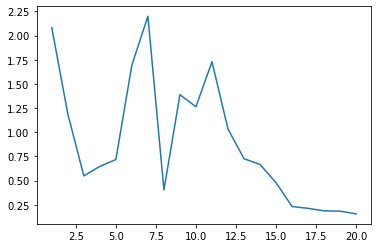

In [628]:
plt.plot(np.arange(1,n_epochs+1), loss_hist)

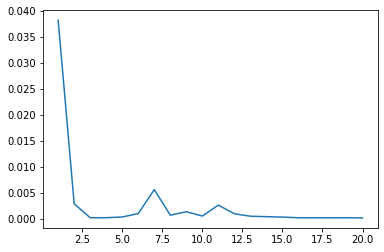

In [629]:
plt.plot(np.arange(1,n_epochs+1), effective_loss_hist)

**Important remark:** Using an SGD optimizer gives much better results on 5 epochs than ADAM. Look at the result for the first forecast (first entry of the training set):

In [630]:
z,h=sRNN_model(T.tensor(X_train[-100:], dtype=T.float32).reshape(n_x_lags,1), None)

In [631]:
z.shape

torch.Size([100, 1])

In [632]:
z[-1]

tensor([0.5613], grad_fn=<SelectBackward0>)

In [633]:
X_test[0]

0.5627905195293119

##### Validation


In [634]:
# Turn off gradient calculations
#with T.no_grad():
T.set_grad_enabled(False)

# Ini. validation forecast tensor
Y_hat = T.empty(size = (len(X_test),n_x_lags, n_in_channels))
y_hat = T.empty(size = (len(X_test),))
    
# Init. hidden state
hidden_state = None

# Get input tensor for i=0
i=0
input_data_i = T.tensor(X_train[-n_x_lags:] , dtype = T.float32)
    
# Compute forecast y_hat[0]
Y_hat[i,:,:], hidden_state = sRNN_model(input_data_i.reshape(n_x_lags,n_in_channels), hidden_state)
y_hat[i] = Y_hat[i,-1,0]
#print(f"y_hat[{i}] = {y_hat[i].item()}")
    
    
# Compute next len(X_train)-1 forecasts
for i in range(1, len(X_test)):

    # Get input tensor
    ### Shift previous entries of input by one
    temp_tensor = T.clone(input_data_i[1:])
    input_data_i[:n_x_lags-1] = temp_tensor
    ### Add previous forecast to last entry of input_data_i
    input_data_i[-1] = y_hat[i-1]

    # Compute forecast y_hat[i]
    Y_hat[i,:,:], hidden_state = sRNN_model(input_data_i.reshape(n_x_lags,n_in_channels), hidden_state)
    y_hat[i] = Y_hat[i,-1,0]
    #print(f"y_hat[{i}] = {y_hat[i].item()}")

Use inverse transform of *ts_scaler* (*MinMaxScaler()*) to plot the results:

In [635]:
# Re-Scaled Y_hat
#scY_hat = ts_scaler.inverse_transform(Y_hat.numpy().reshape(1,-1))[0,:]
scY_hat = ts_scaler.inverse_transform(y_hat.numpy().reshape(1,-1))[0,:]

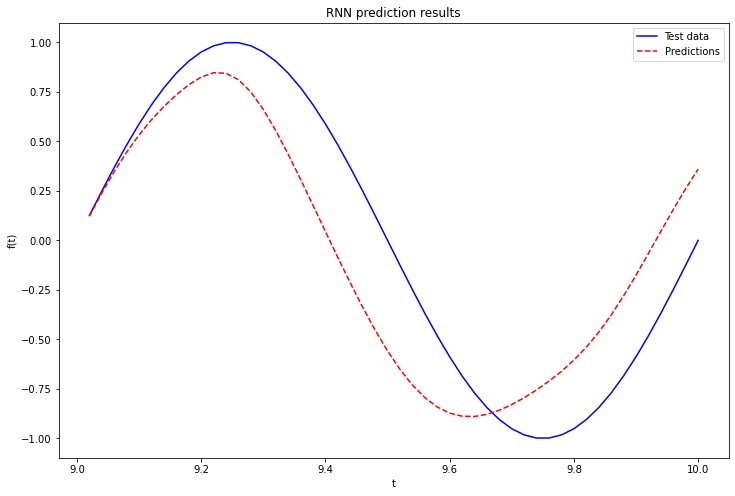

In [636]:
# Plot test data vs predictions.
s = t[-len(X_test):]
plt.figure(figsize = (12,8))
plt.plot(s,X_test_ini,'b', label='Test data')
plt.plot(s,scY_hat,'r--', label='Predictions')
plt.xlabel('t')
plt.ylabel('f(t)')
plt.title('RNN prediction results')
plt.legend()
plt.show()

___________________________________________________________________

## Elman RNN in PyTorch (Cohen's dataset)



_____________________________________________________________________________________

### More complicated data

Here I'm generating the dataset that Micheal Cohen presents in his DUDL course.

In [97]:
# Generate synthetic data (Cohen's)
t_c = np.linspace(start=0, stop=10, num=1001)
S_ini = np.sin(2*np.pi*t_c+np.cos(2*np.pi*t_c))

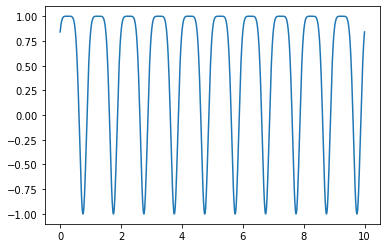

In [98]:
plt.plot(t_c, S_ini)

In [99]:
# Test percentage and index
test_data_percentage = 0.1
# Train-test split
S_train = S_ini[:len(S_ini)-int(len(S_ini)*test_data_percentage)]
S_test = S_ini[len(S_ini)-int(len(S_ini)*test_data_percentage):]

In [100]:
S_train.shape

(901,)

In [101]:
S_test.shape

(100,)

### Model class

In [23]:
# Version 5

class sRNN(Module):
    
    # Constructor
    def __init__(self, input_size, hidden_size,\
                 num_layers=1, nonlinearity="tanh", output_size=1):
        
        # What is this for?
        super().__init__()
        
        # Hyperparams
        self.input_size = input_size # No. of input channels (NOT length)
        self.hidden_size = hidden_size # No. of components of hidden state
        self.num_layers = num_layers # No. of RNN units
        self.nonlinearity = nonlinearity # Activation of RNN unit
        self.output_size = output_size # No. of output channels
        
        
        # Layers
        self.rnn_layer = RNN(input_size = self.input_size, hidden_size = self.hidden_size,\
                            num_layers = self.num_layers,nonlinearity = self.nonlinearity)
        
        self.out_layer = nn.Linear(in_features = self.hidden_size, out_features = self.output_size)
    
    # Forward pass
    def forward(self, X, h):
        
        X_out, h = self.rnn_layer(X, h)
        y = self.out_layer(X_out)
        return y, h.detach()

________________________________________________________

## Training and validation


In [124]:
del sRNN_model, loss, optimizer

In [125]:
# Turn on gradient calculations
T.set_grad_enabled(True)

# Params
n_in_channels =1
hidden_size = 10
n_x_lags = 100
n_out_channels =1

# Inst. model and set its weights to double precision
### We take the number of hidden units equal to length of input sequences
sRNN_model = sRNN(input_size = n_in_channels, hidden_size=hidden_size, \
                  num_layers = 1, nonlinearity='tanh', output_size=n_out_channels)
#sRNN_model.double()

# Loss function:
sRNN_loss_fn = nn.MSELoss() # Note: MSELoss() requires T.float64 
#sRNN_loss_fn.double()

# Optimizer:
optimizer = T.optim.Adam(params = sRNN_model.parameters(), lr = 0.001) # THIS ONE GIVES BEST RESULTS
#optimizer = T.optim.SGD(params = sRNN_model.parameters(), lr = 0.01) # Gives better training than ADAM
#optimizer = T.optim.RMSprop(params = sRNN_model.parameters(), lr = 0.001)


In [52]:
# Turn on gradient calculations
T.set_grad_enabled(True)

In [126]:
###########################################
##### TRAINING ON Y_i[-1] OF LENGTH 1 #####
###########################################


# Initializations
'''
    INSTANTIATE THE MODEL FIRST!
    This cell requires:
    n_in_channels =1
    n_x_lags = 50
    n_out_channels =1
'''
n_epochs = 20
batch_size = 1
# The following could be viewed as our batches
n_y_samples = len(S_train)-n_x_lags

# Timer init.
train_begin_time = datetime.now()
# Output vector loss history (many-to-many loss)
loss_hist = np.empty(shape = n_epochs)
# Effective loss (many-to-one loss)
effective_loss_hist = np.empty(shape = n_epochs)

# Loop over epochs:
for epoch in range(n_epochs):
    
    #delta_y = np.empty(shape = n_y_samples)
    hidden_state = None
    epoch_losses = np.empty(shape = n_y_samples)
    epoch_eff_losses = np.empty(shape = n_y_samples)
    
    # Loop over samples/batches
    for i in range(n_y_samples):
        
        # Set up inputs and outputs of the state system
        X_i = T.tensor(S_train[i:i+n_x_lags], dtype = T.float32).reshape(n_x_lags, n_in_channels)
        Y_i = T.tensor(S_train[i+1:i+n_x_lags+1], dtype = T.float32).reshape(n_x_lags, n_in_channels)
        
        '''
        ## MANY-TO-ONE
        # Predict Y_hat_i 
        Y_hat_i, hidden_state = sRNN_model(X_i, hidden_state)
        #y_hat_i = Y_hat_i[-1,0]
        y_hat_i = Y_hat_i[-1]
        
        # Many-to-many loss
        loss = sRNN_loss_fn(Y_hat_i[-1], Y_i[-1])# Gives warning about computation errors without the .double()
        epoch_losses[i] = T.sqrt(T.sum((Y_hat_i-Y_i).view(n_x_lags)**2)).item()
        # Many-to-one loss (Delta y)
        epoch_eff_losses[i] = loss.item() # Delta of y
        '''
        
        
        ## MANY-TO-MANY
        # Predict Y_hat_i 
        Y_hat_i, hidden_state = sRNN_model(X_i, hidden_state)
        #y_hat_i = Y_hat_i[-1,0]
        y_hat_i = Y_hat_i[-1]
        
        # Many-to-many loss
        loss = sRNN_loss_fn(Y_hat_i, Y_i)# Gives warning about computation errors without the .double()
        epoch_losses[i] = loss.item()
        # Many-to-one loss (Delta y)
        epoch_eff_losses[i] = Y_hat_i[-1]-Y_i[-1]
        
        # Perform one optimization step
        optimizer.zero_grad()
        loss.backward() 
        optimizer.step()
        
    # END OF BATCH LOOP
    
    # Losses
    '''
    ## MANY-TO-ONE
    loss_hist[epoch] = np.mean(epoch_losses)#loss.item()
    effective_loss_hist[epoch] = np.mean(epoch_eff_losses) # RMSE of the delta_y_i's
    '''
    
    ## MANY-TO-ONE
    loss_hist[epoch] = np.mean(epoch_losses)#loss.item()
    effective_loss_hist[epoch] = np.sqrt(np.mean(epoch_eff_losses**2)) # RMSE of the delta_y_i's
    
    # Verbose
    print(f"Epoch: {epoch+1}; Vector loss: {loss_hist[epoch]}; Effective loss: {effective_loss_hist[epoch]}")

# END EPOCH LOOP

print(f"Training finished. Elapsed time = {datetime.now()-train_begin_time}")

Epoch: 1; Vector loss: 0.0688880028970657; Effective loss: 0.27577373738300215
Epoch: 2; Vector loss: 0.00046692188735004893; Effective loss: 0.01986070336756006
Epoch: 3; Vector loss: 0.00028336918419770565; Effective loss: 0.015233437632151332
Epoch: 4; Vector loss: 0.00021019821652861197; Effective loss: 0.013060765933103355
Epoch: 5; Vector loss: 0.00016633999654872065; Effective loss: 0.011478629789662404
Epoch: 6; Vector loss: 0.00013043716367729154; Effective loss: 0.009820462776879925
Epoch: 7; Vector loss: 7.183011266068334e-05; Effective loss: 0.006589445775605315
Epoch: 8; Vector loss: 4.07807982618591e-05; Effective loss: 0.005398865894516822
Epoch: 9; Vector loss: 3.8558339142315724e-05; Effective loss: 0.006148085550043378
Epoch: 10; Vector loss: 4.117790692422356e-05; Effective loss: 0.006363193775873845
Epoch: 11; Vector loss: 0.00013952875038460556; Effective loss: 0.012137435427812005
Epoch: 12; Vector loss: 8.057016574402111e-05; Effective loss: 0.008677889705561492


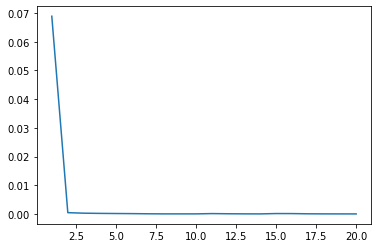

In [127]:
plt.plot(np.arange(1,n_epochs+1), loss_hist)

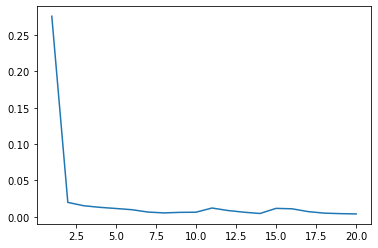

In [128]:
plt.plot(np.arange(1,n_epochs+1), effective_loss_hist)

**Important remark:** Using an SGD optimizer gives much better results on 5 epochs than ADAM. Look at the result for the first forecast (first entry of the training set):

In [129]:
z,h=sRNN_model(T.tensor(S_train[-100:], dtype=T.float32).reshape(n_x_lags,1), None)

In [130]:
z.shape

torch.Size([100, 1])

In [131]:
z[-1]

tensor([0.8679], grad_fn=<SelectBackward0>)

In [132]:
S_test[0]

0.8727748972850792

##### Validation


In [111]:
S_test.shape

(100,)

In [146]:
# Turn off gradient calculations
#with T.no_grad():
T.set_grad_enabled(False)

# Ini. validation forecast tensor
Y_hat = T.empty(size = (len(S_test),n_x_lags, n_in_channels))
y_hat = T.empty(size = (len(S_test),))
H = T.empty(size=(len(S_test),hidden_size))
    
# Init. hidden state
hidden_state = None

# Get input tensor for i=0
i=0
input_data_i = T.tensor(S_train[-n_x_lags:] , dtype = T.float32)
    

# MANY-TO-ONE
# Compute forecast y_hat[0]
Y_hat[i,:,:], hidden_state = sRNN_model(input_data_i.reshape(n_x_lags,n_in_channels), hidden_state)
y_hat[i] = Y_hat[i,-1,0]
H[i,:] = hidden_state[0,:]
    
# Compute next len(X_train)-1 forecasts
for i in range(1, len(S_test)):

    # Get input tensor
    ### Shift previous entries of input by one
    temp_tensor = T.clone(input_data_i[1:])
    input_data_i[:n_x_lags-1] = temp_tensor
    ### Add previous forecast to last entry of input_data_i
    input_data_i[-1] = y_hat[i-1]

    # Compute forecast y_hat[i]
    Y_hat[i,:,:], hidden_state = sRNN_model(input_data_i.reshape(n_x_lags,n_in_channels), hidden_state)
    y_hat[i] = Y_hat[i,-1,0]
    H[i,:] = hidden_state[0,:]
    

Use inverse transform of *ts_scaler* (*MinMaxScaler()*) to plot the results:

In [142]:
# Re-Scaled Y_hat
#scY_hat = ts_scaler.inverse_transform(Y_hat.numpy().reshape(1,-1))[0,:]
np_y_hat = y_hat.numpy()

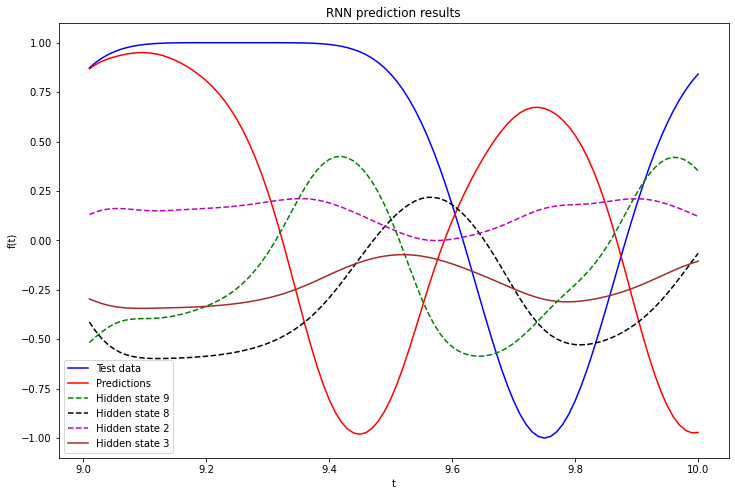

In [153]:
# Plot test data vs predictions.
s = t_c[-len(S_test):]
plt.figure(figsize = (12,8))
plt.plot(s,S_test,'b', label='Test data')
plt.plot(s,np_y_hat,'r', label='Predictions')
plt.plot(s,H[:,9].numpy(),'g--', label='Hidden state 9')
plt.plot(s,H[:,8].numpy(),'k--', label='Hidden state 8')
plt.plot(s,H[:,2].numpy(),'m--', label='Hidden state 2')
plt.plot(s,H[:,3].numpy(),'brown', label='Hidden state 3')
plt.xlabel('t')
plt.ylabel('f(t)')
plt.title('RNN prediction results')
plt.legend()
plt.show()

In [145]:
hidden_state[0,:].shape

torch.Size([10])

### Out of sample forecasting

In [138]:
# Forecast horizon
n_fhor = 50
    
# Ini. validation forecast tensor
Z_hat = T.empty(size = (n_fhor,n_x_lags, n_in_channels))
z_hat = T.empty(size = (n_fhor,))

# Get input tensor for i=0
i=0
input_data_i = T.tensor(S_test, dtype = T.float32)
    

# Compute Y_hat[0]
hidden_state = None
# Compute forecast z_hat[0]
Z_hat[i,:,:], hidden_state = sRNN_model(input_data_i.reshape(n_x_lags,n_in_channels), hidden_state)
z_hat[i] = Z_hat[i,-1,0]
    
# Compute next len(X_train)-1 forecasts
for i in range(1, n_fhor):

    # Get input tensor
    ### Shift previous entries of input by one
    temp_tensor = T.clone(input_data_i[1:])
    input_data_i[:n_x_lags-1] = temp_tensor
    ### Add previous forecast to last entry of input_data_i
    input_data_i[-1] = z_hat[i-1]

    # Compute forecast
    # Compute forecast z_hat[0]
    Z_hat[i,:,:], hidden_state = sRNN_model(input_data_i.reshape(n_x_lags,n_in_channels), hidden_state)
    z_hat[i] = Z_hat[i,-1,0]

In [139]:
# Re-Scaled Y_hat
np_z_hat = z_hat.numpy()

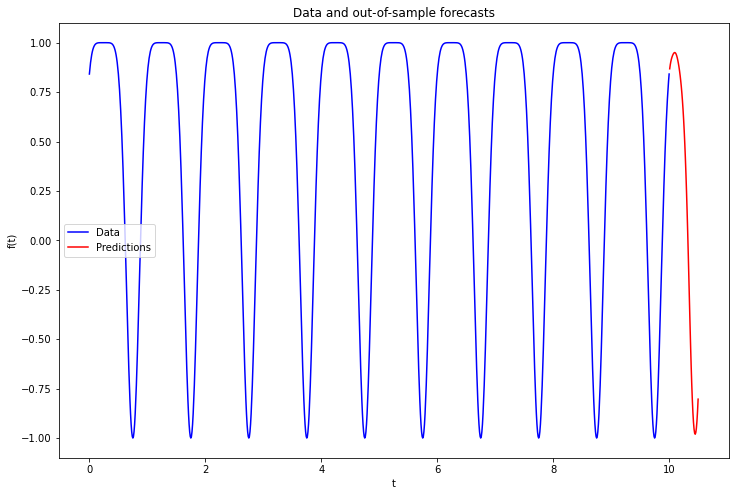

In [140]:
# Plot original dataset and forecasts
plt.figure(figsize = (12,8))
plt.xlabel('t')
plt.ylabel('f(t)')

plt.plot(t_c,S_ini,'b', label='Data')

# 
t_f = np.arange(start = t_c[-1]+0.01, stop = t_c[-1]+0.01*(n_fhor+1), step = 0.01)
plt.plot(t_f,np_z_hat,'r', label='Predictions')

plt.title('Data and out-of-sample forecasts')
plt.legend()
plt.show()

___________________________________________________________________

### 2.d - Out of sample forecasting

For the RNN first. Let's forecast the next 25 points after the test data. We'll keep the same model, without retraining over the entire dataset (as an initial try).

In [65]:
# Turn off gradient calculations
#with T.no_grad():
T.set_grad_enabled(False)

if True: # Just in case I need to put this in a context manager
    
    # Forecast horizon
    n_fhor = 25
    
    # Ini. validation forecast tensor
    Z_hat = T.empty(size = (n_fhor,))

    # Get input tensor for i=0
    i=0
    input_data_i = T.tensor(X_test, dtype = T.float64)
    

    # Compute Y_hat[0]
    Z_hat[i] = sRNN_model(input_data_i.reshape(1, n_x_lags))
    
    # Compute next len(X_train)-1 forecasts
    for i in range(1, n_fhor):

        # Get input tensor
        ### Shift previous entries of input by one
        temp_tensor = T.clone(input_data_i[1:])
        input_data_i[:n_x_lags-1] = temp_tensor
        ### Add previous forecast to last entry of input_data_i
        input_data_i[-1] = Z_hat[i-1]

        # Compute forecast
        Z_hat[i] = sRNN_model(input_data_i.reshape(1, n_x_lags))

In [66]:
# Re-Scaled Y_hat
scZ_hat = ts_scaler.inverse_transform(Z_hat.numpy().reshape(1,-1))[0,:]

In [ ]:
# Plot original dataset and forecasts
plt.figure(figsize = (12,8))
plt.xlabel('t')
plt.ylabel('f(t)')

plt.plot(t,X_ini,'b', label='Data')

# 
t_f = np.arange(start = t[-1]+0.1, stop = t[-1]+0.1*(n_fhor+1), step = 0.1)
plt.plot(t_f,scZ_hat,'r', label='Predictions')

plt.title('Data and out-of-sample forecasts')
plt.legend()
plt.show()

____________________________________________________________________________________________________________________

___________________________________________________________

# Appendix: Previous Attempts

A collection of failures.

________________________________________________________________________

## Attempt 5: 

I made too many modifications to no avail in the 4th attempt. I used some of M. Cohen's code on my dataset, but it fails miserably for reasons that are beyond me. This 5th attempt starts to give results that make sense. What I changed is:
* Now I pass the hidden state as an argument.
* In the class definition of the RNN, I detach the hidden state from the computational graph with *h.detach()*, otherwise I get an error message in the training.
* The output *Y_hat* of the forward pass is of dimension *(n_x_lags, n_in_channels)*. However, the error is computed on the very last component *Y_hat[-1]*.
* I tried SGD, RMSprop and ADAM for the optimizers, along with various learning rates, and 10 hidden state units as an initial try. SGD converges too slowly: It looks like I will need about 100 epochs before the loss is below 0.001. However, with 20 or 50 epochs, the validation results are nearly linear. 
* ADAM gave some better results with a learning rate of 0.001 and 20 epochs instead of 50. Higher learn rates gave bad convergence. The validation gave periodic data in this case, but there were too many periods.
* RMSprop gave a result that is slightly better than ADAM with 20 epochs. The validation forecasts were indeed periodic, but the amplitude was decaying. The result was slightly better when I took 40 epochs, then worse with 80 epochs. I changed the number of hidden units from 10 to 5 then 25, which solved the number of periods, but not the decay issue.
* Continuing with RMSprop, taking 50 hidden units and 50 epochs gave the same behavior as SGD, meaning those near constant forecasts. The results were slightly better with 20 hidden state units and 50 epochs, but still very bad.


### Elman RNN 

In [73]:
# Version 5

class sRNN(Module):
    
    # Constructor
    def __init__(self, input_size, hidden_size,\
                 num_layer=1, nonlinearity="tanh", output_size=1):
        
        # What is this for?
        super().__init__()
        
        # Hyperparams
        self.input_size = input_size # No. of input channels (NOT length)
        self.hidden_size = hidden_size # No. of components of hidden state
        self.nonlinearity = nonlinearity # Activation of RNN unit
        self.output_size = output_size # No. of output channels
        
        
        # Layers
        self.rnn_layer = RNN(input_size = self.input_size, hidden_size = self.hidden_size,\
                            nonlinearity = self.nonlinearity)
        
        self.out_layer = nn.Linear(in_features = self.hidden_size, out_features = self.output_size)
    
    # Forward pass
    def forward(self, X, h):
        
        X_out, h = self.rnn_layer(X, h)
        y = self.out_layer(X_out)
        return y, h.detach()

### Training and validation

In [243]:
# Turn on gradient calculations
T.set_grad_enabled(True)

# Params
n_in_channels =1
n_x_lags = 50
n_out_channels =1

# Inst. model and set its weights to double precision
### We take the number of hidden units equal to length of input sequences
sRNN_model = sRNN(input_size = n_in_channels, hidden_size=20, \
                  nonlinearity='tanh', output_size=n_out_channels)
#sRNN_model.double()

# Loss function:
sRNN_loss_fn = nn.MSELoss() # Note: MSELoss() requires T.float64 
#sRNN_loss_fn.double()

# Optimizer:
#optimizer = T.optim.Adam(params = sRNN_model.parameters(), lr = 0.001) # THIS ONE GIVES BEST RESULTS
#optimizer = T.optim.SGD(params = sRNN_model.parameters(), lr = 0.1) # Gives better training than ADAM
optimizer = T.optim.RMSprop(params = sRNN_model.parameters(), lr = 0.001)


In [244]:
###########################################
##### TRAINING ON Y_i[-1] OF LENGTH 1 #####
###########################################


# Initializations
'''
    INSTANTIATE THE MODEL FIRST!
    This cell requires:
    n_in_channels =1
    n_x_lags = 50
    n_out_channels =1
'''
n_epochs = 50
batch_size = 1
# The following could be viewed as our batches
n_y_samples = len(X_train)-n_x_lags

# Timer init.
train_begin_time = datetime.now()
# Output vector loss history (many-to-many loss)
loss_hist = np.empty(shape = n_epochs)
# Effective loss (many-to-one loss)
effective_loss_hist = np.empty(shape = n_epochs)

# Loop over epochs:
for epoch in range(n_epochs):
    
    #delta_y = np.empty(shape = n_y_samples)
    hidden_state = None
    epoch_losses = np.empty(shape = n_y_samples)
    epoch_eff_losses = np.empty(shape = n_y_samples)
    
    # Loop over samples/batches
    for i in range(n_y_samples):
        
        # Set up inputs and outputs of the state system
        X_i = T.tensor(X_train[i:i+n_x_lags], dtype = T.float32).reshape(n_x_lags, n_in_channels)
        Y_i = T.tensor(X_train[i+1:i+n_x_lags+1], dtype = T.float32).reshape(n_x_lags, n_in_channels)
        
        # Predict Y_hat_i 
        Y_hat_i, hidden_state = sRNN_model(X_i, hidden_state)
        #y_hat_i = Y_hat_i[-1,0]
        y_hat_i = Y_hat_i[-1]
        
        # Many-to-many loss
        loss = sRNN_loss_fn(Y_hat_i[-1], Y_i[-1])# Gives warning about computation errors without the .double()
        epoch_losses[i] = T.sqrt(T.sum((Y_hat_i-Y_i).view(n_x_lags)**2)).item()
        # Many-to-one loss (Delta y)
        epoch_eff_losses[i] = loss.item() # Delta of y
        
        # Perform one optimization step
        optimizer.zero_grad()
        loss.backward() 
        optimizer.step()
        
    # END OF BATCH LOOP
    
    # Losses
    loss_hist[epoch] = np.mean(epoch_losses)#loss.item()
    effective_loss_hist[epoch] = np.mean(epoch_eff_losses) # RMSE of the delta_y_i's
    
    # Verbose
    print(f"Epoch: {epoch+1}; Vector loss: {loss_hist[epoch]}; Effective loss: {effective_loss_hist[epoch]}")

# END EPOCH LOOP

print(f"Training finished. Elapsed time = {datetime.now()-train_begin_time}")

Epoch: 1; Vector loss: 3.2100312394691524; Effective loss: 0.0010710924106849908
Epoch: 2; Vector loss: 2.8365710602139593; Effective loss: 0.0044790026454832686
Epoch: 3; Vector loss: 2.165355521990474; Effective loss: 0.004378562464295774
Epoch: 4; Vector loss: 2.5189333619024987; Effective loss: 0.0023711638620571157
Epoch: 5; Vector loss: 2.5312249321592715; Effective loss: 0.002804064581046351
Epoch: 6; Vector loss: 1.6725761753662567; Effective loss: 0.0022774602280350056
Epoch: 7; Vector loss: 1.3738417844671265; Effective loss: 0.0013174328497855847
Epoch: 8; Vector loss: 1.4540266405019975; Effective loss: 0.0008627447195038438
Epoch: 9; Vector loss: 1.4497754761108437; Effective loss: 0.0009328353548244387
Epoch: 10; Vector loss: 1.3886551478705798; Effective loss: 0.0007925465339954354
Epoch: 11; Vector loss: 1.3624167553058586; Effective loss: 0.0012642058267995548
Epoch: 12; Vector loss: 0.9624949428357388; Effective loss: 0.00031895079918537974
Epoch: 13; Vector loss: 1.1

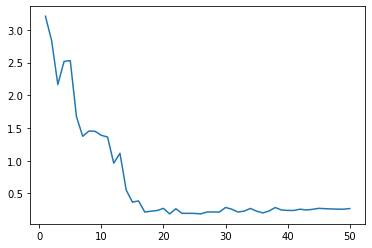

In [245]:
plt.plot(np.arange(1,n_epochs+1), loss_hist)

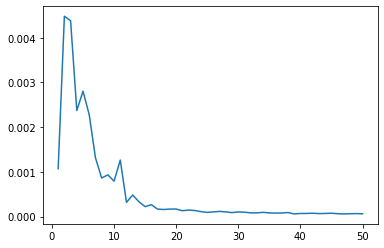

In [246]:
plt.plot(np.arange(1,n_epochs+1), effective_loss_hist)

**Important remark:** Using an SGD optimizer gives much better results on 5 epochs than ADAM. Look at the result for the first forecast (first entry of the training set):

##### Validation


In [251]:
# Turn off gradient calculations
#with T.no_grad():
T.set_grad_enabled(False)

# Ini. validation forecast tensor
Y_hat = T.empty(size = (len(X_test),n_x_lags, n_in_channels))
y_hat = T.empty(size = (len(X_test),))
    
# Init. hidden state
hidden_state = None

# Get input tensor for i=0
i=0
input_data_i = T.tensor(X_train[-n_x_lags:] , dtype = T.float32)
    
# Compute forecast y_hat[0]
Y_hat[i,:,:], hidden_state = sRNN_model(input_data_i.reshape(n_x_lags,n_in_channels), hidden_state)
y_hat[i] = Y_hat[i,-1,0]
print(f"y_hat[{i}] = {y_hat[i].item()}")
    
    
# Compute next len(X_train)-1 forecasts
for i in range(1, len(X_test)):

    # Get input tensor
    ### Shift previous entries of input by one
    temp_tensor = T.clone(input_data_i[1:])
    input_data_i[:n_x_lags-1] = temp_tensor
    ### Add previous forecast to last entry of input_data_i
    input_data_i[-1] = y_hat[i-1]

    # Compute forecast y_hat[i]
    Y_hat[i,:,:], hidden_state = sRNN_model(input_data_i.reshape(n_x_lags,n_in_channels), hidden_state)
    y_hat[i] = Y_hat[i,-1,0]
    print(f"y_hat[{i}] = {y_hat[i].item()}")

y_hat[0] = 0.9479663372039795
y_hat[1] = 0.9612800478935242
y_hat[2] = 0.9644448161125183
y_hat[3] = 0.9575802087783813
y_hat[4] = 0.9423122406005859
y_hat[5] = 0.9207528233528137
y_hat[6] = 0.8943066596984863
y_hat[7] = 0.8640355467796326
y_hat[8] = 0.8308601379394531
y_hat[9] = 0.7956851720809937
y_hat[10] = 0.7592728137969971
y_hat[11] = 0.722212016582489
y_hat[12] = 0.684923529624939
y_hat[13] = 0.6477147936820984
y_hat[14] = 0.6107828617095947
y_hat[15] = 0.574221134185791
y_hat[16] = 0.5380405187606812
y_hat[17] = 0.5021926164627075
y_hat[18] = 0.4665858745574951
y_hat[19] = 0.4311010241508484
y_hat[20] = 0.39560097455978394
y_hat[21] = 0.35994839668273926
y_hat[22] = 0.32402878999710083
y_hat[23] = 0.2877960205078125
y_hat[24] = 0.251296728849411
y_hat[25] = 0.21465392410755157
y_hat[26] = 0.17804953455924988
y_hat[27] = 0.14174163341522217
y_hat[28] = 0.10610228776931763
y_hat[29] = 0.07166943699121475
y_hat[30] = 0.03918784111738205
y_hat[31] = 0.009630918502807617
y_hat[32] =

Use inverse transform of *ts_scaler* (*MinMaxScaler()*) to plot the results:

In [252]:
# Re-Scaled Y_hat
#scY_hat = ts_scaler.inverse_transform(Y_hat.numpy().reshape(1,-1))[0,:]
scY_hat = ts_scaler.inverse_transform(y_hat.numpy().reshape(1,-1))[0,:]

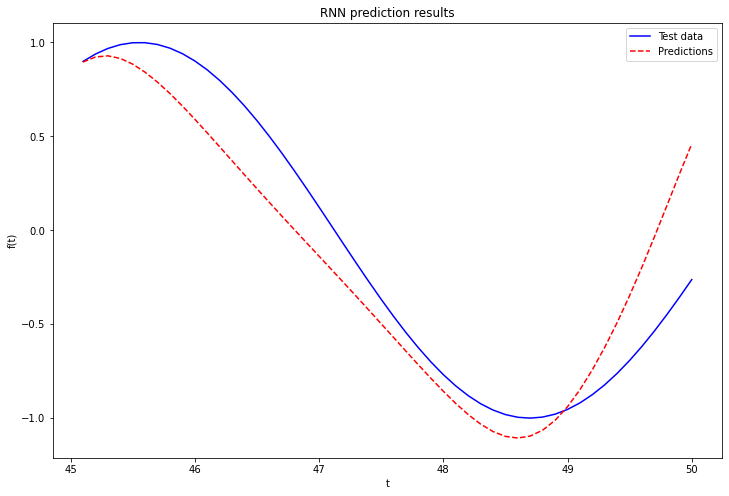

In [253]:
# Plot test data vs predictions.
s = t[-len(X_test):]
plt.figure(figsize = (12,8))
plt.plot(s,X_test_ini,'b', label='Test data')
plt.plot(s,scY_hat,'r--', label='Predictions')
plt.xlabel('t')
plt.ylabel('f(t)')
plt.title('RNN prediction results')
plt.legend()
plt.show()

__________________________________

## Attempt 3: Nothing works

Done of 22/07/21. Nothing worked. I modified the *TimeSeries()* and *sRNN()* class several times to no avail. I changed the learning rate and the optimizer several times too.

- It seems that forcing the many-to-one RNN configuration the same way as MC Cohen doesn't work here. I still don't understand why. To understand how bad the predictions become, see validation below. I will try something different in Attempt 4.

- SGD just doesn't work with this implementation. The loss never goes below 0.1, and it is converging extremely slowly, even with a learning rate of 0.001. I tried with 5, 10, 25 and 30 epochs.

- ADAM started giving acceptable losses once I set the learning rate to 0.1. Anything below that and the losses are a mess.

In [12]:
# Version 2
class TimeSeries(Dataset):
    
    '''
        torch.utils.data.Dataset() subclass for encoding time series
        as states systems. Given a time_series (np.array()) of shape
        (n_time_stamps, n_channels) and a number of time lags n_x_lags, 
        an instance of TimeSeries() re-organizes the data as tensors (X,y),
        where:
        * y is the tensor of "outputs" of the series, of shape (1, n_channels);
        * X is the tensor of "inputs" of the series, of shape (n_x_lags, n_channels),
        
        Attributes:
        * n_x_lags: No. of time lags in input data (int).
        * n_channels: No. of channels in time series.
        * n_out_samples: No. of output samples = len(y) = len(time_series)-n_x_lags
        * X : Input data, dtype=Double, shape = (n_out_samples, n_x_lags, n_channels) (torch.tensor).
        * y : Output data, dtype=Double, shape = (n_out_samples, n_channels) (torch.tensor).
        
        Constructor args:
        * n_x_lags: Number of lags (int)
        * time_series: The original time series (np.array) of shape (N, n_channels).
        
        Example: 
    '''
    
    def __init__(self, time_series, n_x_lags):
        # Number of lags in the input
        self.n_x_lags = n_x_lags
        
        # No. of channels in time series
        self.n_channels = time_series.shape[1]
        
        # No. of output samples
        self.n_out_samples = time_series.shape[0]-n_x_lags
        
        # Output time series (specify Double)
        self.y = T.tensor(time_series[n_x_lags :,:], dtype = T.float64) 
        
        # Inputs (specify Double)
        self.X = T.empty(size = (len(self.y), self.n_x_lags, self.n_channels),\
                         dtype = T.float64) 
        
        for i in range(len(self.y)):
            self.X[i,:,:] = T.tensor(time_series[i:i+n_x_lags,:])

        
    def __len__(self):
        # For number of OUTPUT samples
        return self.n_out_samples
    
    def __getitem__(self,idx):
        # For indexing
        return (self.X[idx,:,:], self.y[idx,:])
    

___________________________________________________________________

## Elman RNN in PyTorch

### Class Definition

In [13]:
class sRNN(nn.Module):
    def __init__(self, input_size, hidden_size, \
                 num_layers=1, nonlinearity="tanh",\
                 output_size = 1):
        super().__init__()
        '''
            Note:
            Read documentation of torch.nn.RNN() carefully for 
            the input/output shapes and contents.
            https://pytorch.org/docs/stable/generated/torch.nn.RNN.html
            Output of sRNN is computed as linear transformation of 
            the output of the last RNN unit.
            
            Agruments:
            * input_size: No. of channels in the input sequences (int)
            * hidden_size: No. of units in the hidden state (int)
            * nonlinearity: Nonlinearity to apply as activation
                            of RNN unit(string)
            * num_layers: No. of Elman RNN units to stack(int, default = 1).
            * output_size: Size of the output y_t (int, default =1).
        '''
        # hyperparameters
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.nonlinearity = nonlinearity
        self.output_size = output_size
        
        
        # Layers
        self.rnn_layer = nn.RNN(input_size=self.input_size, \
                                hidden_size=self.hidden_size, \
                                num_layers=self.num_layers, \
                                nonlinearity=self.nonlinearity)
        self.out_layer = nn.Linear(in_features=self.hidden_size,\
                                   out_features = self.output_size)
        

    def forward(self, X):
        
        H = self.rnn_layer(X) # Note: nn.RNN returns a tuple (out, h_n) of tensors
                              #       out.shape = (length, hidden_size)
                              #       h_n.shape = (, hidden_size)
        y_vec = self.out_layer(H[0]) # Many-to-one obtained by taking last entry
        y = y_vec[-1]
        return y

________________________________________________________

## Training and validation

### Prelims: Instantiate dataset and model

In [14]:
# Dataset
D_ts = TimeSeries(time_series = X_train.reshape(-1,1), n_x_lags = 50)

# Loader
RNN_loader = DataLoader(dataset = D_ts, batch_size = 1, shuffle = False)

In [48]:
del sRNN_model, sRNN_loss_fn, optimizer

In [49]:
# Turn on gradient calculations
T.set_grad_enabled(True)

# Params
n_in_channels =1
n_x_lags = 50
n_out_channels =1

# Inst. model and set its weights to double precision
### We take the number of hidden units equal to length of input sequences
sRNN_model = sRNN(input_size = n_in_channels, hidden_size=n_x_lags, \
                  nonlinearity='tanh', output_size=n_out_channels)
sRNN_model.double()

# Loss function:
sRNN_loss_fn = nn.MSELoss() # Note: MSELoss() requires T.float64 
sRNN_loss_fn.double()

# Optimizer:
#optimizer = T.optim.Adam(params = sRNN_model.parameters(), lr = 0.001)
optimizer = T.optim.Adam(params = sRNN_model.parameters(), lr = 0.05) # Gives better training than ADAM


In [50]:
##### TRAINING #####

# Initializations
n_epochs = 30
batch_size = 1
#n_batches = len(RNN_loader)

# Timer init.
train_begin_time = datetime.now()

loss_hist = np.empty(shape = n_epochs)
model_StateDict_hist = []

# Loop over epochs:
for epoch in range(n_epochs):
    
    # Loop over batches
    for i, (X_i, y_i) in enumerate(RNN_loader):
        
        # Predict y_hat_i labels and compute loss wrt y_i
        y_hat_i = sRNN_model(X_i) 
        loss = sRNN_loss_fn(y_hat_i, y_i).double() # Gives warning about computation errors without the .double()
               
        # Perform one optimization step
        optimizer.zero_grad()
        loss.backward() 
        optimizer.step()
        
        # Update model weights hist
        model_StateDict_hist.append(sRNN_model.state_dict())
        
    # END OF BATCH LOOP
    loss_hist[epoch] = loss.item()
    print(f"Epoch: {epoch+1}; Loss: {loss.item()}.")

# END EPOCH LOOP

print(f"Training finished. Elapsed time = {datetime.now()-train_begin_time}")

C:\Users\zaj20\anaconda3\envs\DeepRL\lib\site-packages\torch\nn\modules\loss.py:529: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([50, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch: 1; Loss: 9.935767127260906e-05.
Epoch: 2; Loss: 4.5842540392368644e-06.
Epoch: 3; Loss: 3.239007502604631e-05.
Epoch: 4; Loss: 0.00010503838741140658.
Epoch: 5; Loss: 3.5722220746726136e-05.
Epoch: 6; Loss: 8.138319102136148e-05.
Epoch: 7; Loss: 4.012106040566066e-06.
Epoch: 8; Loss: 0.00018729699837331123.
Epoch: 9; Loss: 5.375200824957993e-05.
Epoch: 10; Loss: 5.734485442142877e-05.
Epoch: 11; Loss: 9.433746439997536e-06.
Epoch: 12; Loss: 5.836467089160497e-05.
Epoch: 13; Loss: 5.254800439328082e-06.
Epoch: 14; Loss: 2.554742921899505e-05.
Epoch: 15; Loss: 6.819037887707558e-06.
Epoch: 16; Loss: 2.5493310322115264e-06.
Epoch: 17; Loss: 2.3163994052000417e-05.
Epoch: 18; Loss: 5.900594876393868e-05.
Epoch: 19; Loss: 9.844082704787604e-05.
Epoch: 20; Loss: 3.5426897922288534e-05.
Epoch: 21; Loss: 1.4223643028023363e-06.
Epoch: 22; Loss: 3.0259007962077116e-06.
Epoch: 23; Loss: 4.872075719010812e-06.
Epoch: 24; Loss: 6.399487559080666e-05.
Epoch: 25; Loss: 3.7786995580632956e-06.

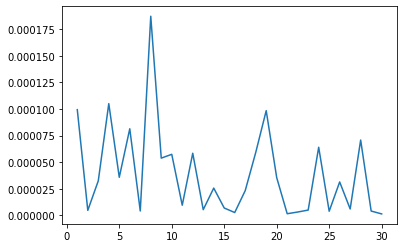

In [51]:
plt.plot(np.arange(1,n_epochs+1), loss_hist)

**Important remark:** Using an SGD optimizer gives much better results on 5 epochs than ADAM. Look at the result for the first forecast (first entry of the training set):

In [18]:
z = sRNN_model(T.tensor(X_train[-50:], dtype=T.float64).reshape(n_x_lags,1))

In [20]:
z[0]

tensor(0.8784, dtype=torch.float64, grad_fn=<SelectBackward0>)

In [31]:
X_test[0]

0.9495513437783747

________________________________________

In [24]:
with T.no_grad():
    
    # Ini. validation forecast tensor
    Y_hat = T.empty(size = (len(X_test),))

    # Get input tensor for i=0
    i=0
    input_data_i = T.tensor(X_train[-n_x_lags:] , dtype = T.float64)
    

    # Compute Y_hat[0]
    Y_hat[i] = sRNN_model(input_data_i.reshape(n_x_lags,1))[0]
    print(f"Y_hat[{i}] = {Y_hat[i].item()}")
    
    # Compute next len(X_train)-1 forecasts
    for i in range(1, len(X_test)):

        # Get input tensor
        ### Shift previous entries of input by one
        temp_tensor = T.clone(input_data_i[1:])
        input_data_i[:n_x_lags-1] = temp_tensor
        ### Add previous forecast to last entry of input_data_i
        input_data_i[-1] = Y_hat[i-1]

        # Compute forecast
        Y_hat[i] = sRNN_model(input_data_i.reshape(n_x_lags,1))[0]
        print(f"Y_hat[{i}] = {Y_hat[i].item()}")

Y_hat[0] = 0.8783625960350037
Y_hat[1] = 0.8784084320068359
Y_hat[2] = 0.8791584968566895
Y_hat[3] = 0.8787972927093506
Y_hat[4] = 0.8789732456207275
Y_hat[5] = 0.8789957165718079
Y_hat[6] = 0.8789997100830078
Y_hat[7] = 0.8789884448051453
Y_hat[8] = 0.8789895176887512
Y_hat[9] = 0.8789879083633423
Y_hat[10] = 0.87898850440979
Y_hat[11] = 0.8789883852005005
Y_hat[12] = 0.8789884448051453
Y_hat[13] = 0.8789883852005005
Y_hat[14] = 0.8789884448051453
Y_hat[15] = 0.8789884448051453
Y_hat[16] = 0.8789884448051453
Y_hat[17] = 0.8789884448051453
Y_hat[18] = 0.8789884448051453
Y_hat[19] = 0.8789884448051453
Y_hat[20] = 0.8789884448051453
Y_hat[21] = 0.8789884448051453
Y_hat[22] = 0.8789884448051453
Y_hat[23] = 0.8789884448051453
Y_hat[24] = 0.8789884448051453
Y_hat[25] = 0.8789884448051453
Y_hat[26] = 0.8789884448051453
Y_hat[27] = 0.8789884448051453
Y_hat[28] = 0.8789884448051453
Y_hat[29] = 0.8789884448051453
Y_hat[30] = 0.8789884448051453
Y_hat[31] = 0.8789884448051453
Y_hat[32] = 0.878988

Use inverse transform of *ts_scaler* (*MinMaxScaler()*) to plot the results:

In [22]:
# Re-Scaled Y_hat
scY_hat = ts_scaler.inverse_transform(Y_hat.numpy().reshape(1,-1))[0,:]

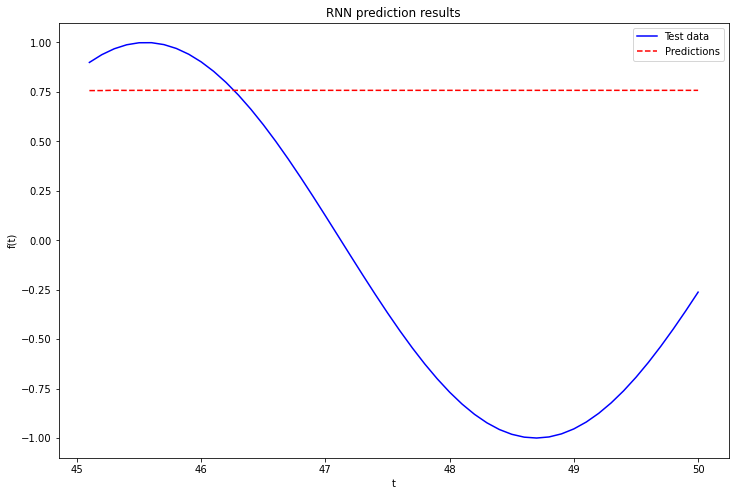

In [23]:
# Plot test data vs predictions.
s = t[-len(X_test):]
plt.figure(figsize = (12,8))
plt.plot(s,X_test_ini,'b', label='Test data')
plt.plot(s,scY_hat,'r--', label='Predictions')
plt.xlabel('t')
plt.ylabel('f(t)')
plt.title('RNN prediction results')
plt.legend()
plt.show()

__________________________________________________________

## Attempt 2: Mistake in implementation

The way I wrote the model initially had an issue, which is connected to how I used the *nn.RNN()* class. I used the length of my sequences as the number of input channels (no. of components in one time-stamp $x_t$). This should have been 1, the same way that the RNN class of Keras doesn't require a number of channels instead of the length.

The changes that should be made in Attempt 3 are the following:

* The *input_size* argument in the call of *sRNN_model()* should be *n_in_channels*=1 instead of *n_x_lags*. It's the same as *nn.RNN()*.

* The *Dataset()* subclass *TimeSeries()* should return tensors of the appropriate size, meaning: *(n_x_lags, n_in_channels)*. Otherwise, the input shape is incompatible with *nn.RNN()*.

In [12]:
class TimeSeries(Dataset):
    
    '''
        Attributes:
        * n_x_lags: No. of time lags in input data (int).
        * X : Input data, dtype=Double, shape = (n_samples, n_x_lags) (torch.tensor).
        * y : Output data, dtype=Double, shape = (n_samples, ) (torch.tensor).
        Constructor args:
        * n_x_lags: Number of input lags (int)
        * time_series: The data (np.array)
    '''
    
    def __init__(self, time_series, n_x_lags):
        # Number of lags in the input
        self.n_x_lags = n_x_lags
        
        # Output time series (specify Double)
        self.y = T.tensor(time_series[n_x_lags :], dtype = T.float64) 
        
        # Inputs (specify Double)
        self.X = T.empty(size = (len(self.y), self.n_x_lags), dtype = T.float64) 
        
        for i in range(len(self.y)):
            self.X[i,:] = T.tensor(time_series[i:i+n_x_lags])

        
    def __len__(self):
        # For number of samples
        return len(self.X)
    
    def __getitem__(self,idx):
        # For indexing
        return (self.X[idx,:], self.y[idx])
    

___________________________________________________________________

### 2.b - Model construction

#### 2.b.1 - Regular RNN

In [12]:
class sRNN(nn.Module):
    def __init__(self, input_size, hidden_size, \
                 num_layers=1, nonlinearity="tanh",\
                 output_size = 1):
        super().__init__()
        '''
            Note:
            Read documentation of torch.nn.RNN() carefully for 
            the input/output shapes and contents.
            https://pytorch.org/docs/stable/generated/torch.nn.RNN.html
            Output of sRNN is computed as linear transformation of 
            the output of the last RNN unit.
            
            Agruments:
            * input_size: Length of input sequence (int)
            * hidden_size: No. of 
            * nonlinearity: Nonlinearity to apply as activation
                            of RNN unit(string)
            * num_layers: No. of Elman RNN units to stack(int, default = 1).
            * output_size: Size of the output y_t (int, default =1).
        '''
        # hyperparameters
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.nonlinearity = nonlinearity
        self.output_size = output_size
        
        
        # Layers
        self.rnn_layer = nn.RNN(input_size=self.input_size, \
                                hidden_size=self.hidden_size, \
                                num_layers=self.num_layers, \
                                nonlinearity=self.nonlinearity)
        self.out_layer = nn.Linear(in_features=self.hidden_size,\
                                   out_features = self.output_size)
        

    def forward(self, X):
        H = self.rnn_layer(X) # Note: nn.RNN returns a tuple of tensors, H[1]=h_n and H[0] =output
        y = self.out_layer(H[0])
        return y

________________________________________________________

### 2.c - Training and validation

#### 2.c.1 - Elman RNN

First, instantiate the TimeSeries() object from synthetic data and make the DataLoader

In [13]:
# Dataset
D_ts = TimeSeries(time_series = X_train, n_x_lags = 50)

# Loader
RNN_loader = DataLoader(dataset = D_ts, batch_size = 1, shuffle = False)

In [14]:
# Check shape and data types of TimeSeries()
print(f"len(D_ts)={len(D_ts)}; \nD_ts.X.shape={D_ts.X.shape}; D_ts.X.dtype={D_ts.X.dtype};")
print(f"D_ts.y.shape={D_ts.X.shape}; D_ts.y.dtype={D_ts.y.dtype};")

# Check shape and data types of elements returned by DataLoader()
print(f"len(RNN_loader)={len(RNN_loader)};")
for j, (A,b) in enumerate(RNN_loader):
    if j==5:
        print(f"For index j={j} of DataLoader, returned object (A,b) with:")
        print(f"A.shape={A.shape}; A.dtype={A.dtype};")
        print(f"b.shape={b.shape}; b.dtype={b.dtype};")


len(D_ts)=401; 
D_ts.X.shape=torch.Size([401, 50]); D_ts.X.dtype=torch.float64;
D_ts.y.shape=torch.Size([401, 50]); D_ts.y.dtype=torch.float64;
len(RNN_loader)=401;
For index j=5 of DataLoader, returned object (A,b) with:
A.shape=torch.Size([1, 50]); A.dtype=torch.float64;
b.shape=torch.Size([1]); b.dtype=torch.float64;


In [44]:
del sRNN_model, sRNN_loss_fn, optimizer

**WARNING:** I did not make this RNN properly apparently. The *input_size* argument is supposed to be the number of channels/features of the input sequence, and not the length of the input sequences. In Keras too, the length of the sequence wasn't a parameter.

In [45]:
# Params
n_x_lags = 50
n_out_features =1

# Inst. model and set its weights to double precision
sRNN_model = sRNN(input_size = n_x_lags, hidden_size=n_x_lags, \
                  nonlinearity='tanh', output_size=1)
sRNN_model.double()

# Loss function:
sRNN_loss_fn = nn.MSELoss() # Note: MSELoss() requires T.float64 
sRNN_loss_fn.double()

# Optimizer:
#optimizer = T.optim.Adam(params = sRNN_model.parameters(), lr = 0.001)
optimizer = T.optim.SGD(params = sRNN_model.parameters(), lr = 0.001) # Gives better training than ADAM


In [17]:
# Check dtype of network parameters
net_params = []
for theta in sRNN_model.parameters():
    net_params.append(theta)
    
j = 5
print(f"For index j={j} of sRNN_model.params():")
print(f"type(net_params[j]) = {type(net_params[j])}")
print(f"net_params[j].shape = {net_params[j].shape}")
print(f"net_params[j].dtype = {net_params[j].dtype}")

For index j=5 of sRNN_model.params():
type(net_params[j]) = <class 'torch.nn.parameter.Parameter'>
net_params[j].shape = torch.Size([1])
net_params[j].dtype = torch.float64


In [18]:
j = 2
print(f"For index j={0} of sRNN_model.params():")
print(f"type(net_params[j]) = {type(net_params[j])}")
print(f"type(net_params[j].data) = {type(net_params[j].data)}")
print(f"net_params[j].data.shape = {net_params[j].data.shape}")
print(f"net_params[j].data.dtype = {net_params[j].data.dtype}")

For index j=0 of sRNN_model.params():
type(net_params[j]) = <class 'torch.nn.parameter.Parameter'>
type(net_params[j].data) = <class 'torch.Tensor'>
net_params[j].data.shape = torch.Size([50])
net_params[j].data.dtype = torch.float64


In [ ]:
sRNN_loss_fn.d

In [46]:
##### TRAINING #####

# Initializations
n_epochs = 5
batch_size = 1
#n_batches = len(RNN_loader)

# Timer init.
train_begin_time = datetime.now()

loss_hist = np.empty(shape = n_epochs)
model_StateDict_hist = []

# Loop over epochs:
for epoch in range(n_epochs):
    
    # Loop over batches
    for i, (X_i, y_i) in enumerate(RNN_loader):
        
        # Predict y_hat_i labels and compute loss wrt y_i
        y_hat_i = sRNN_model(X_i) 
        loss = sRNN_loss_fn(y_hat_i, y_i).double() # Gives warning about computation errors without the .double()
               
        # Perform one optimization step
        optimizer.zero_grad()
        loss.backward() 
        optimizer.step()
        
        # Update model weights hist
        model_StateDict_hist.append(sRNN_model.state_dict())
        
    # END OF BATCH LOOP
    loss_hist[epoch] = loss.item()
    print(f"Epoch: {epoch+1}; Loss: {loss.item()}.")

# END EPOCH LOOP

print(f"Training finished. Elapsed time = {datetime.now()-train_begin_time}")

C:\Users\zaj20\anaconda3\envs\DeepRL\lib\site-packages\torch\nn\modules\loss.py:529: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch: 1; Loss: 0.030835751718440278.
Epoch: 2; Loss: 0.002455259618419537.
Epoch: 3; Loss: 0.00014020668946659027.
Epoch: 4; Loss: 1.8686641228662082e-06.
Epoch: 5; Loss: 2.144055770353219e-06.
Training finished. Elapsed time = 0:00:02.786183


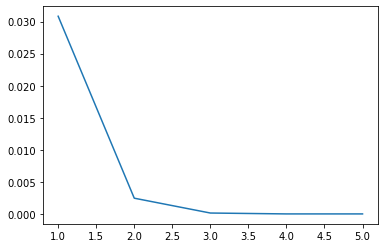

In [47]:
plt.plot(np.arange(1,n_epochs+1), loss_hist)

**Important remark:** Using an SGD optimizer gives much better results on 5 epochs than ADAM. Look at the result for the first forecast (first entry of the training set):

In [48]:
z = sRNN_model(T.tensor(X_train[-50:], dtype=T.float64).reshape(1, n_x_lags))

In [49]:
z.item()

0.9480514524021949

In [50]:
X_test[0]

0.9495513437783747

Save for now:

In [24]:
T.save(sRNN_model, "Torch_sRNN_2207201842")

##### Validation

An improved version of what I did in Keras. 

In [55]:
with T.no_grad():
    
    # Ini. validation forecast tensor
    Y_hat = T.empty(size = (len(X_test),))

    # Get input tensor for i=0
    i=0
    input_data_i = T.tensor(X_train[-n_x_lags:] , dtype = T.float64)
    

    # Compute Y_hat[0]
    Y_hat[i] = sRNN_model(input_data_i.reshape(1, n_x_lags))
    
    # Compute next len(X_train)-1 forecasts
    for i in range(1, len(X_test)):

        # Get input tensor
        ### Shift previous entries of input by one
        temp_tensor = T.clone(input_data_i[1:])
        input_data_i[:n_x_lags-1] = temp_tensor
        ### Add previous forecast to last entry of input_data_i
        input_data_i[-1] = Y_hat[i-1]

        # Compute forecast
        Y_hat[i] = sRNN_model(input_data_i.reshape(1, n_x_lags))

Use inverse transform of *ts_scaler* (*MinMaxScaler()*) to plot the results:

In [60]:
# Re-Scaled Y_hat
scY_hat = ts_scaler.inverse_transform(Y_hat.numpy().reshape(1,-1))[0,:]

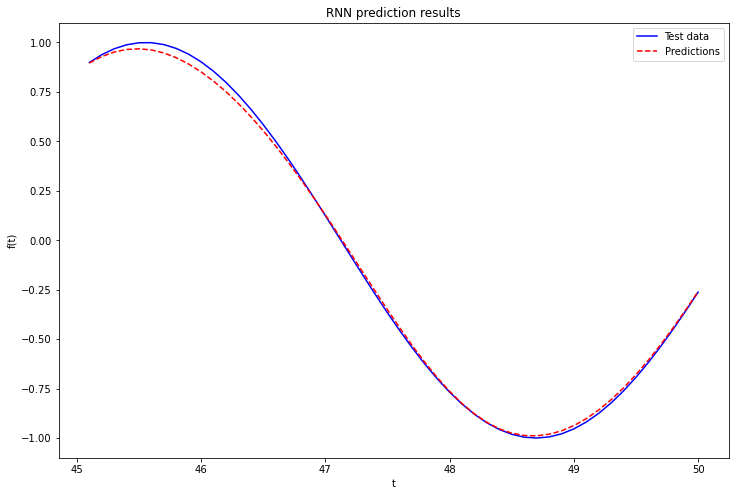

In [61]:
# Plot test data vs predictions.
s = t[-len(X_test):]
plt.figure(figsize = (12,8))
plt.plot(s,X_test_ini,'b', label='Test data')
plt.plot(s,scY_hat,'r--', label='Predictions')
plt.xlabel('t')
plt.ylabel('f(t)')
plt.title('RNN prediction results')
plt.legend()
plt.show()

___________________________________________________________________

### 2.d - Out of sample forecasting

For the RNN first. Let's forecast the next 25 points after the test data. We'll keep the same model, without retraining over the entire dataset (as an initial try).

In [65]:
with T.no_grad():
    
    # Forecast horizon
    n_fhor = 50
    
    # Ini. validation forecast tensor
    Z_hat = T.empty(size = (n_fhor,))

    # Get input tensor for i=0
    i=0
    input_data_i = T.tensor(X_test, dtype = T.float64)
    

    # Compute Y_hat[0]
    Z_hat[i] = sRNN_model(input_data_i.reshape(1, n_x_lags))
    
    # Compute next len(X_train)-1 forecasts
    for i in range(1, n_fhor):

        # Get input tensor
        ### Shift previous entries of input by one
        temp_tensor = T.clone(input_data_i[1:])
        input_data_i[:n_x_lags-1] = temp_tensor
        ### Add previous forecast to last entry of input_data_i
        input_data_i[-1] = Z_hat[i-1]

        # Compute forecast
        Z_hat[i] = sRNN_model(input_data_i.reshape(1, n_x_lags))

In [66]:
# Re-Scaled Y_hat
scZ_hat = ts_scaler.inverse_transform(Z_hat.numpy().reshape(1,-1))[0,:]

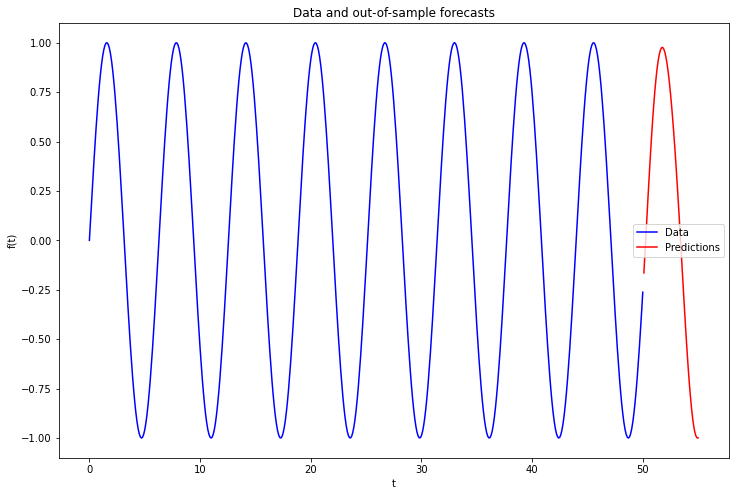

In [67]:
# Plot original dataset and forecasts
plt.figure(figsize = (12,8))
plt.xlabel('t')
plt.ylabel('f(t)')

plt.plot(t,X_ini,'b', label='Data')

# 
t_f = np.arange(start = t[-1]+0.1, stop = t[-1]+0.1*(n_fhor+1), step = 0.1)
plt.plot(t_f,scZ_hat,'r', label='Predictions')

plt.title('Data and out-of-sample forecasts')
plt.legend()
plt.show()

____________________________________

## Attempt 1: RNN results with ADAM

The optimization is pretty bad with ADAM. The results below are typical behavior for this optimizer when used with RNNS.
(Import the classes TimeSeries() and sRNN(), as well as the scaled dataset.)

C:\Users\zaj20\anaconda3\envs\DeepRL\lib\site-packages\torch\nn\modules\loss.py:529: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch: 1; Loss: 0.06353839402287503.
Epoch: 2; Loss: 0.0031656060308228318.
Epoch: 3; Loss: 0.002765503164194921.
Epoch: 4; Loss: 3.7700461739830753e-06.
Epoch: 5; Loss: 0.17606254115033312.
Training finished. Elapsed time = 0:00:04.042843


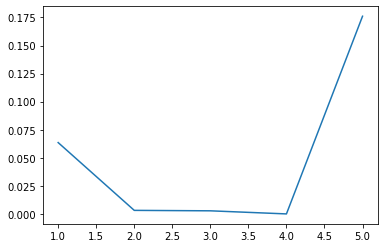

In [25]:
# Dataset
D_ts = TimeSeries(time_series = X_train, n_x_lags = 50)

# Loader
RNN_loader = DataLoader(dataset = D_ts, batch_size = 1, shuffle = False)

#############
### Model ###
#############

n_x_lags = 50

# Inst. model and set its weights to double precision
sRNN_adam = sRNN(input_size = n_x_lags, hidden_size=n_x_lags, \
                  nonlinearity='tanh', output_size=1)
sRNN_adam.double()

# Loss function:
sRNN_loss_adam = nn.MSELoss() # Note: MSELoss() requires T.float64 
sRNN_loss_adam.double()

# Optimizer:
#optimizer = T.optim.Adam(params = sRNN_model.parameters(), lr = 0.001)
optimizer_adam = T.optim.Adam(params = sRNN_adam.parameters(), lr = 0.001) # Gives better training than ADAM


################
### Training ###
################

# Initializations
n_epochs = 5
batch_size = 1

# Timer init.
train_begin_time = datetime.now()

loss_hist = np.empty(shape = n_epochs)

# Loop over epochs:
for epoch in range(n_epochs):
    
    # Loop over batches
    for i, (X_i, y_i) in enumerate(RNN_loader):
        
        # Predict y_hat_i labels and compute loss wrt y_i
        y_hat_i = sRNN_adam(X_i) 
        loss = sRNN_loss_adam(y_hat_i, y_i).double() # Gives warning about computation errors without the .double()
               
        # Perform one optimization step
        optimizer_adam.zero_grad()
        loss.backward() 
        optimizer_adam.step()
        
    # END OF BATCH LOOP
    loss_hist[epoch] = loss.item()
    print(f"Epoch: {epoch+1}; Loss: {loss.item()}.")

# END EPOCH LOOP

print(f"Training finished. Elapsed time = {datetime.now()-train_begin_time}")

# Plot losses
plt.plot(np.arange(1,n_epochs+1), loss_hist)